## Creating Word vectors for training Sentences using Doc2Vec Algorithm

#### Overview

Step 1: Extract sentences which are actual questions from various sources and clean them ( word tokenization, lemmatizing,
removing DATE and PERSON name entities from message) etc.


Step 2: Extract sentences which are random sentences taken from amazon reviews, random qoutes and clean them using the same pre processing techniques as above.


Step 3: Create a single dataframe which contains a mix of sentences ( from questions to non- questions and label them as

'1' for questions and '0' for non questions.

Step 4: Perform / visualize from Exploratory data analysis on the text data we are dealing with.


Step 5: Create number vectors for each sentence in the final data frame ( made from step 3) and store them in a csv file, along with the training parameters of Doc2Vector.




#### Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt # To print plots
import spacy # To recognize named entities from english
import re # To write regular expression rules

from nltk.tokenize import word_tokenize # To perform word tokenization
from nltk.stem import WordNetLemmatizer # To perform lemmatization on each word
from collections import Counter, defaultdict


from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import glob # To enable reading multiple files 

C:\Users\amith\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Spacy object to load different entities in english
spec = spacy.load('en')

# Object to lemmatize each word: convert them to a base form
lem_obj = WordNetLemmatizer()

#### STEP 1: Actual questions

In [3]:

#Loading the text file with sentences which are actual questions
train_ques =  pd.read_csv('C:\\Users\\amith\\Desktop\\Toucan AI_Test\\datasets_train\\Questions\\TRAINQ.txt',
                          sep='\r\n',
                          header=None,
                          engine='python')

In [4]:
len(train_ques)

8452

In [5]:
# Converting the dataframe with questions as a list of strings
train_ques_values = train_ques.values.tolist()

In [6]:
def clean(data):
    
    '''This is a helper function which pre-processes the text in a format which can be fed 
    to a Doc2Vec to train the sentences.
    
    
    Inputs:
    
    data: A list of strings. 
            Shape = N documents
    
    Returns: A list of strings.
            Shape = N documents
    
    Steps:
    
    a -> for each sentence in the text data, convert it to string (to avoid special character issues) and look for any named
    entities in that particular sentence. Entities such as name of a person and date will be replaced in the string.
    
    b-> The sentence would then be tokenized into individual words, transformed to lower case, and then lemmatized ( turning into its base form)
    A word is only lemmatized if it either a digit or an alphabet ( to avoid special characters)
    
    c-> This *cleaned* sentence is then appended to a list as a single line.
    
    d-> This process continues untill all the sentences in the input data are iterated over and finally this method returns
    
    a list of strings, where each index contains a sentence which is pre-processed.
    '''
    
    # List to hold the cleaned strings
    fd = []
    
    # Iterating over each sentence 
    for sent in data:
        
        # Convert it to string , to avoid encoding issues
        sent = str( sent[0] )
        
        # Identify named entities in this string
        ne = spec(sent)
        
        # Iterating over each named entity in the string
        for ents in ne.ents:
            
            # If an entity like PERSON's name or DATE is in this string,
            # replace that with an empty string
            if ents.label_ is "PERSON" or ents.label_ is "DATE":
                
                sent = sent.replace(ents.text, '')
        
        # After removing such entities, tokenize sentence into individual words,
        # if a word is an alphabet or a digit only then add that word to a sentence by converting it to base form : lemmatizing
        result = ' '.join([lem_obj.lemmatize(word.lower())
                           for word in word_tokenize(sent) if word.isalpha() or word.isdigit() ]) 
        
        # Add the resulting clean string to the final list
        fd.append(result)
        
        
    # Return a list containing all the cleaned strings in each row
    return fd

In [7]:
# Clean the sentences which are actual questions
data = clean(train_ques_values)

# Make a data frame with only questions
df_ques = pd.DataFrame(data, columns=['Text'])

# Add a column of ones with the same no. of samples as the no. of sentences, they will be used as a prediction label
df_ques['label'] = np.ones(shape=len(df_ques), dtype=int)

len(df_ques)

8452

#### STEP 2: Random text which are not questions

In [8]:
# Path to read rest of the files for training
path =r'C:\\Users\\amith\\Desktop\\Toucan AI_Test\\datasets_train' 

# Read all text files in this folder
allFiles = glob.glob(path + "/*.txt")

# List to hold data frame with all the text files
list_ = []

# Iterating over each text file 
for file_ in allFiles:
    
    df = pd.read_csv(file_,
                     index_col=None,
                     header=None,
                     sep='\r\n', # Seperator for a new line in windows
                     encoding='utf-8',
                     engine='python')
    
    list_.append(df)

# Concatenate multiple text files into a single series of values
review_files = pd.concat(list_, axis = 0, ignore_index = True)

# Clean all the sentences in the merged data frame and copy the data in to a data frame
review_files = pd.DataFrame( 
    clean(review_files.values.tolist()),
    columns=['text'] )

In [9]:
len(review_files)

2000

In [10]:
os.chdir('C:\\Users\\amith\\Desktop\\Toucan AI_Test\\datasets_train')

There are 2000 documents / sentences with reviews from Amazon, IMDB and Yelp

In [11]:
# Data frame to hold the csv file with random text sentences from different contexts
df_csv1 =  pd.read_csv('agreement-sentence-agreement-DFE.csv',
                        usecols=['premise'] # Only read the column 'premise' from the data set
                        ,encoding='utf-8',
                       engine='python')

# Data frame to hold the csv file with random text sentences from different contexts
df_csv2 =  pd.read_csv('plausible-sentences-DFE.csv',
                       usecols=['sentence'] # Only read the column 'premise' from the data set
                          ,encoding='utf-8',
                       engine='python')


# Clean the text data 
df_csv1['text'] = clean(df_csv1.values.tolist() )

df_csv2['text'] = clean(df_csv2.values.tolist() )

In [12]:
# Concatenating or merging multiple data frames in to one Series which holds all random text sentences
df_nonques = pd.concat([ df_csv1['text'],
                        df_csv2['text'],
                        review_files['text'] ],
                       axis = 0   ) # Merge row wise

# Converting series to data frmae
df_nonques = pd.DataFrame(df_nonques.values, columns=['Text'])

# Giving all the sentences a label of zero, which depicts the sentence not being a question
df_nonques['label'] = np.zeros(shape=(len(df_nonques)    ) , dtype=int    )

##### STEP 3: Combine all sentences which are questions and random text

In [13]:
df_fd = pd.concat([df_ques, df_nonques], axis = 0)

In [14]:
df_fd.head()

,Text,label
0,how did serfdom develop in and then leave russia,1
1,what film featured the character,1
2,how can i find a list of celebrity real name,1
3,what fowl grab the spotlight after the chinese...,1
4,what is the full form of,1


In [15]:

# Shuffle the sentences for randomness
df_fd = df_fd.sample(frac=1)

In [16]:
df_fd.head()

,Text,label
822,a city worker pushing a mobile garbage bin,0
3831,who patented the first phonograph,1
7275,who is band director in,1
2487,the phone load super,0
5603,what is goldenseal,1


In [17]:
# Saving to a CSV file

df_fd.to_csv('C:\\Users\\amith\\Desktop\\Toucan AI_Test\\QNQ.csv',sep=',')

#### STEP 4: Visualize text data

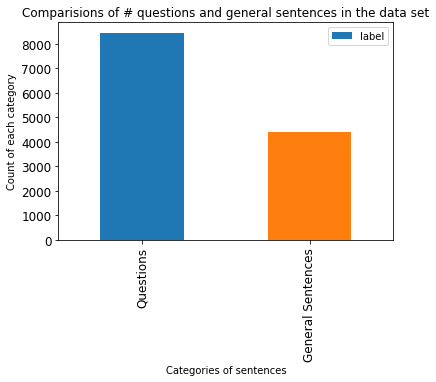

In [18]:
# Calculating total count for each unique label in the data set and plotting a bar plot
ax = df_fd['label'].value_counts().plot(kind='bar', 
                                   
                                   title='Comparisions of # questions and general sentences in the data set',
                                   
                                  legend=True,
                                  
                                  fontsize = 12,
                                  
                             )

ax.set_xticks(range(2)) 

ax.set_xticklabels(['Questions', 'General Sentences'], rotation=90)

plt.xlabel('Categories of sentences')

plt.ylabel('Count of each category')

plt.show()

In [19]:
count = Counter(df_fd['Text'])

In [20]:
count.most_common(15) # Calculating the top 15 common documents

[('who is', 36),
 ('what is', 22),
 ('who wa', 21),
 ('when wa born', 11),
 ('what doe the name mean', 10),
 ('what doe mean', 9),
 ('where is', 8),
 ('who killed', 7),
 ('how did die', 7),
 ('great phone', 6),
 ('what is famous for', 6),
 ('what happened to', 6),
 ('what is the speed of the mississippi river', 6),
 ('what is address', 5),
 ('where wa born', 5)]

##### Note:        

There are 36 documents in the training data set which are questions and which start with text 'who is'. Similarly,

22 documents for with text 'what is'.

##### 4.1 -> Visualizing named entities inside each question sentence before pre-processing them

In [21]:
labels_b_c = [] # List to hold different named entities in the original text sentences which were not cleaned

In [22]:
# Iterating over each sentence, which are questions
for doc in train_ques_values:
    
    # Identifying named entities in that sentence
    entities = spec(doc[0])
    
    # List to hold different labels of our interest
    req_lab = ["FACILITY", "LOCATION", "ORGANIZATION", "GPE", "PERSON"]
    
    # Iterating over each named entity in the  string
    for ent in entities.ents:
        
        # If this label is in our required labels 
        if ent.label_ in req_lab:
            
            # Append that label to the list
            labels_b_c.append(ent.label_);
            
# Identifying unique labels and counting the occurence of each label            
unq_lab_b_c ,values_b_c = np.unique(labels_b_c, return_counts=True)

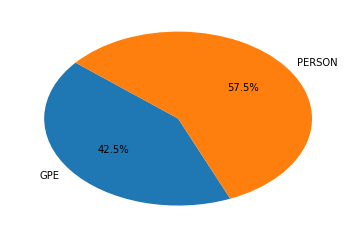

In [23]:
# Plotting a pie plot 
plt.pie(values_b_c, labels=unq_lab_b_c, autopct='%1.1f%%', startangle=140)

# Display the chart
plt.show()

#### In our original data set, with only questions, of all the named entities across all sentences we have about 57.5% of them are names of a 'PERSON' and 42.5% are names of 'Geo Political Entities' such as names of a Location or Landmark

##### 4.2 -> Visualizing named entities in the whole data set after cleaning them

In [24]:
labels = [] # List to hold different named entities in the original text sentences which were not cleaned

In [25]:
# Slicing only questions from our data frame and iterating over all such sentences
for doc in df_fd.loc[df_fd.label == 1, 'Text']:
    
    # Identifying named entities in that sentence
    entities = spec(doc)
    
    # List to hold different labels of our interest
    req_lab = ["FACILITY", "LOCATION", "ORGANIZATION", "GPE", "PERSON"]
    
    # Iterating over each named entity in the  string
    for ent in entities.ents:
        
        # If this label is in our required labels 
        if ent.label_ in req_lab:
            
            # Append that label to the list
            labels.append(ent.label_);
            
# Identifying unique labels and counting the occurence of each label                       
unq_lab ,values = np.unique(labels, return_counts=True)

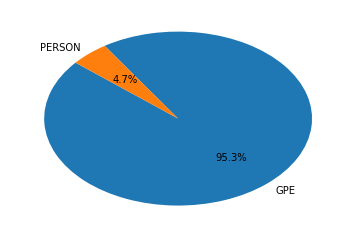

In [26]:
# Plotting a pie plot
plt.pie(values, labels=unq_lab, autopct='%1.1f%%', startangle=140)

# Display the chart
plt.show()

#### In our clean data set, we sliced all the questions , of all the named entities across all sentences we have about 95.3% of them are names of a 'PERSON' and 4.7% are names of 'Geo Political Entities' such as names of a Location or Landmark. So, we can see a clear improvement in our cleaned sentences with less noise.

In [27]:
os.chdir('C:\\Users\\amith\\Desktop\\Toucan AI_Test')

#### Step 5: Create vectors for the documents

In [28]:
class D2V():
    
    ''' This class is used to convert each sentence which is a text document into a vector of float values.
    
    These vectors are then saved on to a text file using numpy package. All the documents will be fed to the neural
    
    network in a single batch.'''
    
    def __init__(self,
                 vec_size,
                 num_workers,
                 epochs,
                 text_data):
        
        '''Constructor to initialize required values. This function internally calls required 
        
        member functions which are used to pre-process, train and test the documents.'''
        
        # No. of dimensions / columns in each vector
        self.vec_size = vec_size
        
        
        # No. of threads for parallel processing of training phase
        self.num_workers = num_workers
        
        # No. of epochs to train the algorithm on
        self.epo = epochs
        
        # Data frame which contains the text data and labels
        self.data = text_data
        
        #  Pre Process the data
        self._Pre_process_data()
        
        # Vectorize it
        self._Vectorize_it()
        
        # Train it
        self._Train_it()
        
        # Test it
        self._Test_it()
            
    def _Pre_process_data(self):
        
        '''This is a private function used to clean or pre-process the data.
        The pre-processing steps include word tokenization, 
        checking wether a word is an alphabet or a digit, removing special symbols etc.
        
        Inputs: N/A
        
        Outputs: N/A
        '''
        
        # Accessing only the text column of the data frame and converting a series to list
        user_mes = self.data['Text'].tolist()
        
        
        # Iterating over each sentence and splitting sentence into individual words and removing tag mentions
        rt_mes = [word_tokenize(sent.split('@')[1])[1:]  if sent.startswith('@') 
                  else word_tokenize(sent)  for sent in user_mes]
        
       

        
        # Iterating over each sentence and checking if a word is either an alphabet or a digit 
        self.words = [[word for word in sent if word.isalpha() or word.isdigit()] 
                      for sent in rt_mes]
        
        # Accessing all the labels in the data set
        self.labels = self.data['label'].tolist()
        
    def _Vectorize_it(self):
        
        '''This is a private function used to convert each document to a number-based vector form.
        
        This function makes use of the TaggedDocument class from the gensim's Doc2Vec package to convert/tag each
        
        sentence to its corresponding label and then use such a tagged document to train the algorithm.
        
        Each tagged document has a sentence which is split into individual words and its corresponding label.''' 
        
        self.documents = [TaggedDocument(sent, [lab]) for sent,lab in list(      zip(self.words,  self.labels)  )   ]
        
        #Shuffle the document for better accuracy
        np.random.shuffle(self.documents)
        
        self.model = Doc2Vec(vector_size= self.vec_size , # Shape / Dimensions / # of columns in each vector sample
                             
                             window= 15 , # No. of documents which are similar to a given document
                             
                             min_count=1,
                             
                             workers= self.num_workers) # No. of parallel threads to train the algorithm
        
        # Slicing no. of training documents
        self.train_docs = self.documents[   : int( len(self.documents ) * 0.85 )  ] 
        
        
        # Slicing no. of test documents
        self.test_docs = list (   np.array(   self.documents[  -1200 : ]).T[0]    )
                       
    def _Train_it(self):
        
        '''This is a private function which is used to train the Neural network which was already built.
        
        After training the network, this function saves the trained model ( with its hyper parameters and weights) in a .Doc2Vec file
        
        and also saves the vector representation of documents in a text file.'''
        
        
        # Building a simple bag of words model with unique words in the entire text data / corpus
        self.model.build_vocab(self.train_docs)       
        
        
        # Training the neural network to convert a OneHot Encoded feature to set of float values
        self.model.train(self.train_docs , # Actual documents to train on
                         total_examples=len(self.train_docs), # total no.of training examples
                         epochs= self.epo)# No. of times to continue the training process
         
        

        # Save the trained model ( weights, hyper parameters ), so that it can be re used later 
        self.model.save('Ques_Classify_vectors.doc2vec')
        
        
        # List to hold vector values of each document in the original document
        all_train_vectors = []
        
    # Saving all the word vectors for the trained documents in a seperate text file so that they can be used to train later
        #on another NN
        
        # Iterating over each document in the data set
        for doc in self.data['Text']:
            
            # Getting it's vector form by calling model's infer_vector method
            vector_doc = self.model.infer_vector(word_tokenize( doc) )
            
            # Appending the result to a list
            all_train_vectors.append(vector_doc)
            
        
        # Save all the vectors to a text file with a new line as a seperator for each sample
        np.savetxt('Vectors_QNQ_Data.txt',
                   X=all_train_vectors,
                   delimiter=',',
                   newline='\n')
                 
    def _Test_it(self):
        
        '''This is a private function which is used to test the Neural network which was already built and trained.
        
        This function randomly choose 10 documents from the test set and predict the most similar document to the current document,
        
        the idea is that if two documents are very similar they both may have a same meaning, in other words both might be questions
        
        so we can infer whether a sentence is a question or not.'''
        
        
        # Iterate over last 10 test documents
        for doc in self.test_docs[:10]:
            
            # Get the vector representation of the text file
            vec = self.model.infer_vector(doc)
            
            # Find out a vector which is the *most similar* one to the current vector by using cosine distance,
            
            # in other words, this most similar document will have a tag / label which will be given to the sample which was
            # tested on, thus classifying the label of the sample
            pred = self.model.docvecs.most_similar(  positive = [vec], topn= 1  )
            
            # Print the results
            print('For the document: ', doc ,' - Predicted label is: ', pred)

In [29]:
doc_obj = D2V(400, # No. of columns for each sample
              10, # No. of parallel workers
              1100, # No. of epochs
              df_fd) # Data frame containing text and its corresponding labels

For the document:  ['where', 'is', 'inoco', 'based']  - Predicted label is:  [(1, 0.1459503322839737)]
For the document:  ['which', 'college', 'did', 'play', 'basketball', 'for']  - Predicted label is:  [(1, 0.1584547907114029)]
For the document:  ['to', 'my', 'phone', 'without', 'effort']  - Predicted label is:  [(0, 0.03358972817659378)]
For the document:  ['what', 'russian', 'seaport', 'ha', 'a', 'name', 'meaning', 'lord', 'of', 'the', 'east']  - Predicted label is:  [(1, 0.1653847098350525)]
For the document:  ['what', 'crooner', 'joined', 'the', 'andrew', 'sister', 'for', 'pistol', 'packin', 'mama']  - Predicted label is:  [(0, 0.23367753624916077)]
For the document:  ['which', 'city', 'in', 'china', 'ha', 'the', 'largest', 'number', 'of', 'foreign', 'financial', 'company']  - Predicted label is:  [(0, 0.02192353457212448)]
For the document:  ['this', 'is', 'not', 'a', 'yacht', 'it', 'is', 'a', 'galley']  - Predicted label is:  [(0, 0.13824987411499023)]
For the document:  ['what'

For each sentence, it's predicted label and cosine similarity score of it's document is printed. Ex: for the first document, the algorithm found a *similar sample* with cosine similarity score is 20 %, which happened to be the closest sample. So, we took the label of the * similar sample* and assigned it to our current sample.